[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nipunbatra/ml-teaching/blob/master/notebooks/names.ipynb)


In [31]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import time
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [32]:
torch.__version__

'2.8.0'

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
device

device(type='cpu')

In [35]:
# Get some names from https://github.com/MASTREX/List-of-Indian-Names

In [36]:
import os
import requests

# Download only if file doesn't exist
if not os.path.exists('names-long.csv'):
    print("Downloading names dataset...")
    url = "https://raw.githubusercontent.com/balasahebgulave/Dataset-Indian-Names/master/Indian_Names.csv"
    response = requests.get(url)
    with open('names-long.csv', 'w') as f:
        f.write(response.text)
    print("Download complete!")
else:
    print("File already exists, skipping download.")

File already exists, skipping download.


In [7]:
!head names-long.csv

,Name
0,aabid
1,aabida
2,aachal
3,aadesh
4,aadil
5,aadish
6,aaditya
7,aaenab
8,aafreen


In [8]:
!tail names-long.csv

6476,zeshan
6477,zhini
6478,ziarul
6479,zile
6480,zina
6481,zishan
6482,ziyabul
6483,zoya
6484,zuhaib
6485,zuveb


In [37]:
words = pd.read_csv('names-long.csv')["Name"]
words = words.str.lower()
words = words.str.strip()
words = words.str.replace(" ", "")

words = words[words.str.len() > 2]
words = words[words.str.len() < 10]

# Randomly shuffle the words
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

# Remove words having non alphabets
words = [word for word in words if word.isalpha()]
words[:10]


['mithalesh',
 'shetal',
 'abishak',
 'maalti',
 'anuj',
 'doly',
 'jamir',
 'shafi',
 'jauli',
 'bharkah']

In [38]:
len(words)

6184

In [11]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
pprint(itos)

{0: '.',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}


In [39]:
block_size = 5 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

..... ---> m
....m ---> i
...mi ---> t
..mit ---> h
.mith ---> a
mitha ---> l
ithal ---> e
thale ---> s
hales ---> h
alesh ---> .
..... ---> s
....s ---> h
...sh ---> e
..she ---> t
.shet ---> a
sheta ---> l
hetal ---> .
..... ---> a
....a ---> b
...ab ---> i
..abi ---> s
.abis ---> h
abish ---> a
bisha ---> k
ishak ---> .
..... ---> m
....m ---> a
...ma ---> a
..maa ---> l
.maal ---> t
maalt ---> i
aalti ---> .
..... ---> a
....a ---> n
...an ---> u
..anu ---> j
.anuj ---> .
..... ---> d
....d ---> o
...do ---> l
..dol ---> y
.doly ---> .
..... ---> j
....j ---> a
...ja ---> m
..jam ---> i
.jami ---> r
jamir ---> .
..... ---> s
....s ---> h
...sh ---> a
..sha ---> f
.shaf ---> i
shafi ---> .
..... ---> j
....j ---> a
...ja ---> u
..jau ---> l
.jaul ---> i
jauli ---> .
..... ---> b
....b ---> h
...bh ---> a
..bha ---> r
.bhar ---> k
bhark ---> a
harka ---> h
arkah ---> .
..... ---> b
....b ---> u
...bu ---> s
..bus ---> h
.bush ---> a
busha ---> r
ushar ---> a
shara ---> .
..... ---> r

In [40]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([44325, 5]), torch.int64, torch.Size([44325]), torch.int64)

In [41]:
# Embedding layer for the context

emb_dim = 4
emb = torch.nn.Embedding(len(stoi), emb_dim)


In [42]:
emb.weight

Parameter containing:
tensor([[-0.6689, -0.2634, -0.4392, -1.4236],
        [-0.2674, -0.0776,  0.4902,  1.3839],
        [ 0.7724,  0.7208, -0.1855,  0.3637],
        [-1.8472, -0.9477,  0.1617,  0.4472],
        [-0.3250,  0.7947,  0.7655,  0.4505],
        [ 0.8521, -1.0797, -0.6078, -1.0739],
        [-1.8542, -0.3032, -2.0662,  1.2668],
        [ 0.2777,  0.1355, -1.9901, -0.2022],
        [ 1.7310,  0.0140,  0.4774,  0.1562],
        [ 0.0723, -0.5635,  1.9034, -0.2987],
        [ 0.0996, -1.9110,  1.4175,  0.1072],
        [ 0.9163,  0.4375, -0.7374, -0.5285],
        [-1.6790,  1.2778,  1.1785,  0.9385],
        [ 1.5782,  0.3598,  2.0228,  0.5676],
        [ 1.6236,  1.6892, -0.8365,  0.8409],
        [ 0.2735,  1.3549,  1.3547,  0.8793],
        [-0.5510, -1.2227,  0.8813, -0.0925],
        [-0.5195,  0.7681,  0.2261,  1.6737],
        [-0.9731,  0.1642,  0.2832, -1.8166],
        [ 0.2875, -0.8558, -1.6788,  0.1840],
        [-0.5074,  0.3619, -0.7801,  1.8238],
        [-1.

In [43]:
emb.weight.shape

torch.Size([27, 4])

<Axes: title={'center': 'Embedding Visualization (PCA: 0.34, 0.28 var explained)'}>

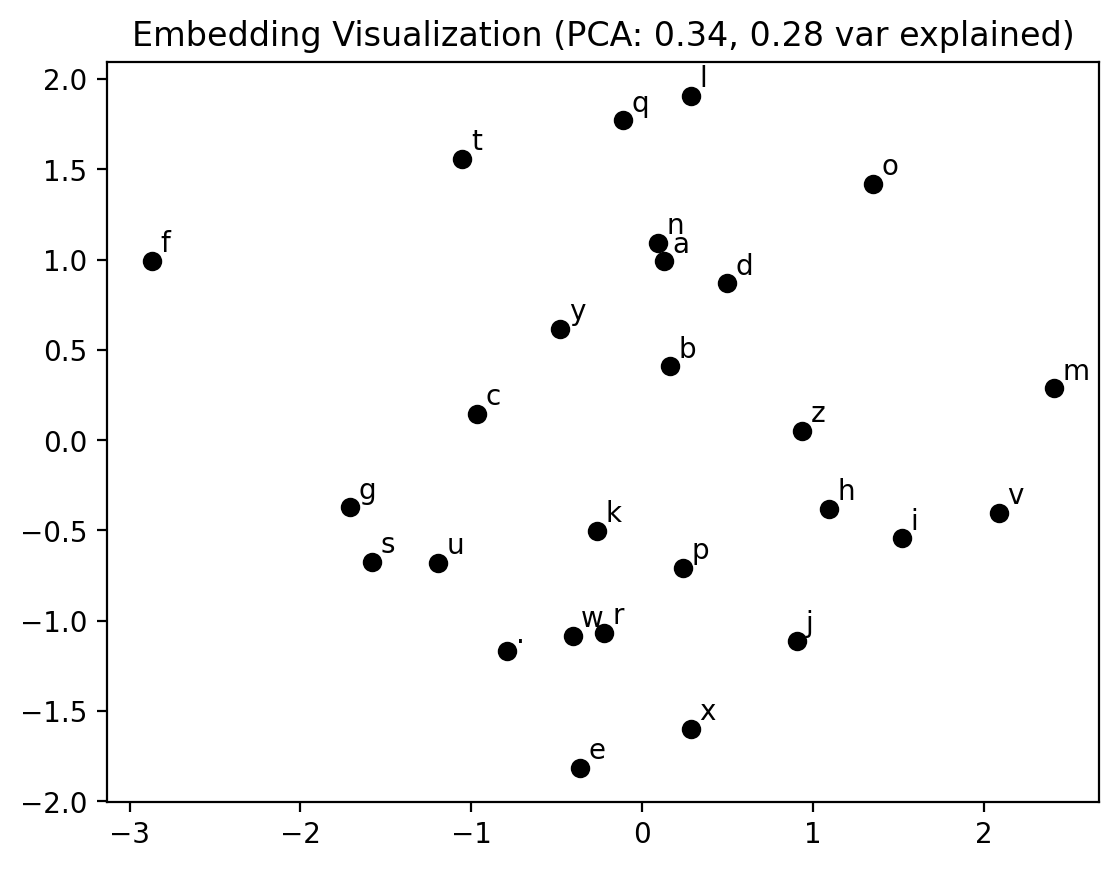

In [47]:
# Function to visualize the embedding in 2d space

def plot_emb(emb, itos, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # Get embedding weights and handle different dimensions
    weights = emb.weight.detach().cpu().numpy()
    
    if weights.shape[1] == 2:
        # For 2D embeddings, plot directly
        for i in range(len(itos)):
            x, y = weights[i]
            ax.scatter(x, y, color='k')
            ax.text(x + 0.05, y + 0.05, itos[i])
    elif weights.shape[1] > 2:
        # For higher dimensions, use PCA to reduce to 2D
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        weights_2d = pca.fit_transform(weights)
        
        for i in range(len(itos)):
            x, y = weights_2d[i]
            ax.scatter(x, y, color='k')
            ax.text(x + 0.05, y + 0.05, itos[i])
            
        # Add explained variance info to title
        explained_var = pca.explained_variance_ratio_
        ax.set_title(f'Embedding Visualization (PCA: {explained_var[0]:.2f}, {explained_var[1]:.2f} var explained)')
    else:
        # For 1D embeddings, create a scatter plot with y=0
        for i in range(len(itos)):
            x = weights[i, 0]
            y = 0
            ax.scatter(x, y, color='k')
            ax.text(x + 0.05, y + 0.05, itos[i])
        ax.set_ylabel('(1D embedding)')
    
    return ax

plot_emb(emb, itos)

In [48]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x))
    x = self.lin2(x)
    return x


In [49]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def print_model_summary(model):
    print("Model Summary:")
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:
            params = sum(p.numel() for p in module.parameters())
            print(f"{name:<20} {params:,} parameters")
    print(f"\nTotal trainable parameters: {count_params(model):,}\n")


def train_model(model, X, Y, epochs=500, batch_size=1024, lr=1e-3, wd=1e-2, print_every=100):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.CrossEntropyLoss()

    losses, times = [], []
    for epoch in range(epochs):
        start = time.time()
        total_loss, n_batches = 0, 0

        for i in range(0, X.shape[0], batch_size):
            x_batch = X[i:i+batch_size]
            y_batch = Y[i:i+batch_size]

            logits = model(x_batch)
            loss = loss_fn(logits, y_batch)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()
            n_batches += 1

        avg_loss = total_loss / n_batches
        losses.append(avg_loss)
        times.append(time.time() - start)

        if epoch % print_every == 0:
            print(f"Epoch {epoch:4d} | Loss: {avg_loss:.4f} | Time: {times[-1]:.2f}s")

    return losses, times


In [68]:
logits_demo = torch.tensor([0.1, 2.0, 2.5, -10.0])
prob_demo = F.softmax(logits_demo, dim=0)
itos_demo = {0: 'a', 1: 'b', 2: 'c', 3: 'd'}
counts = {ch: 0 for ch in itos_demo.values()}
for _ in range(1000):
    ix_demo = torch.distributions.categorical.Categorical(logits=logits_demo).sample()
    ch_demo = itos_demo[ix_demo.item()]
    counts[ch_demo] += 1
    #print(ch_demo)
print(counts)
print(prob_demo*1000)

{'a': 65, 'b': 348, 'c': 587, 'd': 0}
tensor([5.3450e+01, 3.5736e+02, 5.8919e+02, 2.1957e-03])


In [50]:
g = torch.Generator()
g.manual_seed(4000002)
def generate_name(model, itos, stoi, block_size, max_len=10):
    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        context = [0] * block_size
        name = ''
        for i in range(max_len):
            x = torch.tensor(context).view(1, -1).to(device)
            y_pred = model(x)
            ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
            ch = itos[ix]
            if ch == '.':
                break
            name += ch
            context = context[1:] + [ix]
    # Set model back to training mode
    model.train()
    return name

Model Summary:
_orig_mod.emb        108 parameters
_orig_mod.lin1       1,344 parameters
_orig_mod.lin2       1,755 parameters

Total trainable parameters: 3,207

Generated names before training:
 1. jomngybshs
 2. mcrmhh
 3. wrhkwunynm
 4. iddj
 5. i
 6. rw
 7. n
 8. mhitqjrzvb
 9. bqjvocwvjn
10. ycmijupxbk

Embedding visualization before training:


<Axes: title={'center': 'Embedding Visualization (PCA: 0.49, 0.26 var explained)'}>

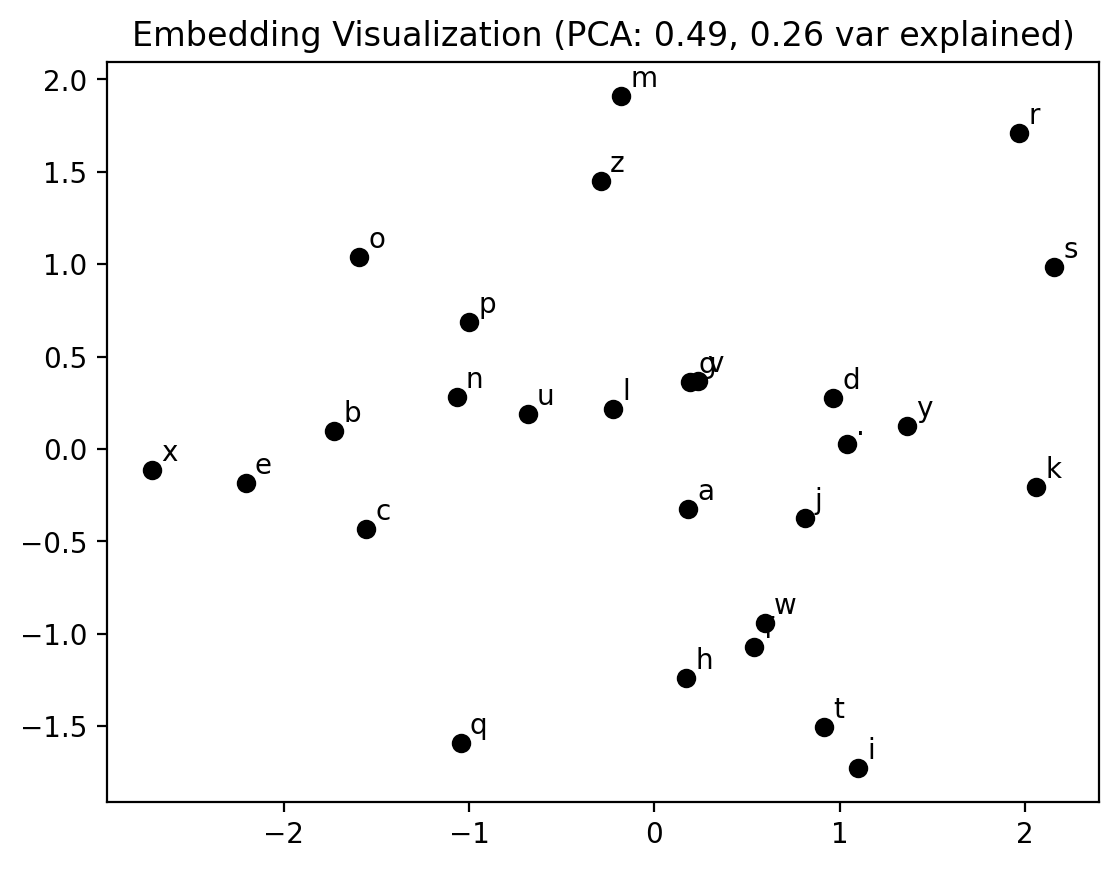

In [51]:
# Create enhanced model and show before training

model = NextChar(block_size, len(stoi), emb_dim, hidden_size=64).to(device)
model = torch.compile(model)

## Model parameters:
print_model_summary(model)

# Generate some names before training
print("Generated names before training:")
print("="*50)
for i in range(10):
    name = generate_name(model, itos, stoi, block_size)
    print(f"{i+1:2d}. {name}")

# Visualize embedding before training
print("\nEmbedding visualization before training:")
plot_emb(model.emb, itos)



In [52]:
losses, times = train_model(model, X, Y, epochs=1200, batch_size=4096, lr=0.001, wd=0.01, print_every=200)  

Epoch    0 | Loss: 3.2415 | Time: 0.10s
Epoch  200 | Loss: 2.0479 | Time: 0.03s
Epoch  400 | Loss: 2.0058 | Time: 0.02s
Epoch  600 | Loss: 1.9897 | Time: 0.03s
Epoch  800 | Loss: 1.9808 | Time: 0.02s
Epoch 1000 | Loss: 1.9745 | Time: 0.02s



Embedding visualization after training:


<Axes: title={'center': 'Embedding Visualization (PCA: 0.37, 0.29 var explained)'}>

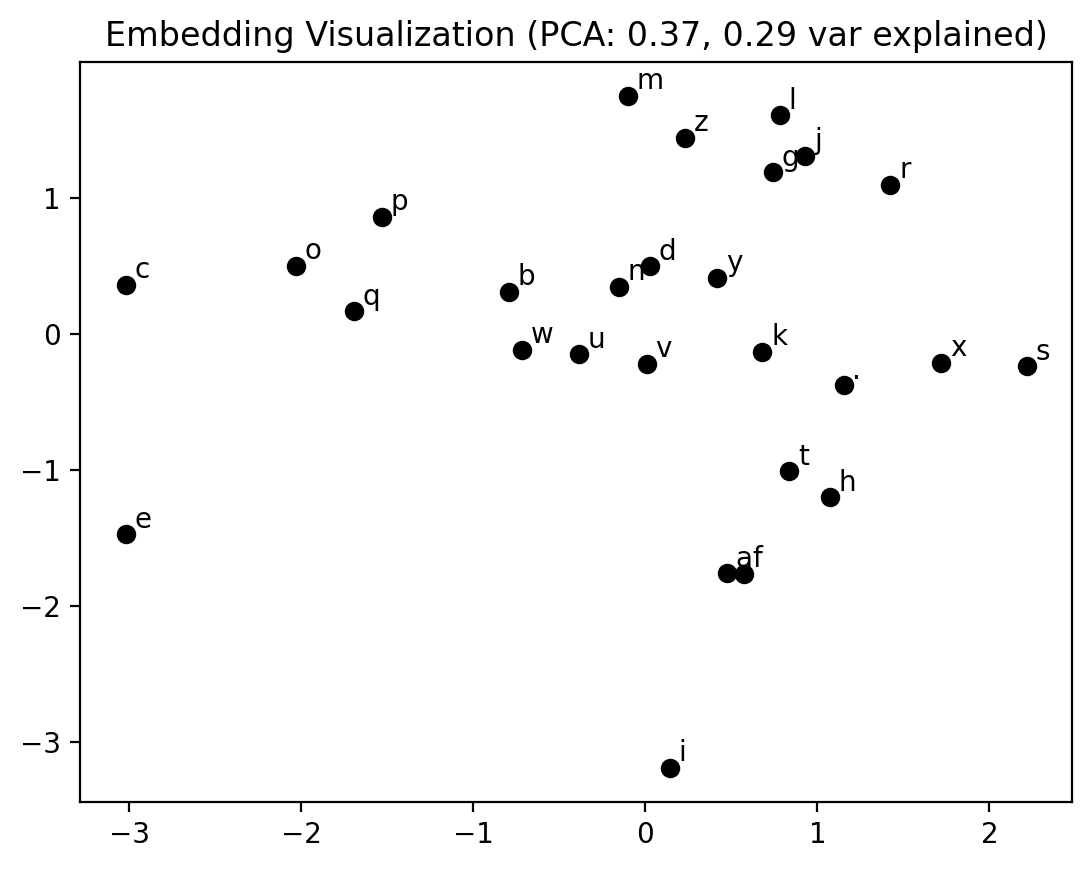

In [53]:
# Visualize the embedding post training
print("\nEmbedding visualization after training:")

plot_emb(model.emb, itos)

In [54]:
# Generate some names after training
print("Generated names after training:")
print("="*50)
for i in range(10):
    name = generate_name(model, itos, stoi, block_size)
    print(f"{i+1:2d}. {name}")  


Generated names after training:
 1. sehed
 2. parvitiya
 3. anul
 4. arisa
 5. hidast
 6. murskeep
 7. jarmthnaxz
 8. sarnath
 9. garwana
10. galli


In [69]:
class NextCharResidual(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.fc_in = nn.Linear(block_size * emb_dim, hidden_size)
        
        # Residual MLP block
        self.block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size),
        )
        
        self.bn_out = nn.BatchNorm1d(hidden_size)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_in(x)
        residual = x
        x = self.block(x) + residual  # Residual connection
        x = torch.relu(self.bn_out(x))
        x = self.fc_out(x)
        return x


In [70]:
model = NextCharResidual(block_size, len(stoi), emb_dim, hidden_size=128, dropout=0.2).to(device)


In [71]:
print_model_summary(model)

print("="*60)
print("Before Training Samples:")
print("="*60)
model.eval()
with torch.no_grad():
    for i in range(10):
        name = generate_name(model, itos, stoi, block_size)
        print(f"{i+1:2d}. {name}")

Model Summary:
emb                  108 parameters
fc_in                2,688 parameters
block.0              16,512 parameters
block.1              256 parameters
block.2              0 parameters
block.3              0 parameters
block.4              16,512 parameters
bn_out               256 parameters
fc_out               3,483 parameters

Total trainable parameters: 39,815

Before Training Samples:
 1. eqxymusqva
 2. pipehedzuh
 3. mstykelnex
 4. wwisfbumlr
 5. caauhram
 6. l
 7. bieicanlkb
 8. nxudgixmiu
 9. zhlvjzitff
10. kxykqnvbzb


In [72]:
model.train()
losses, times = train_model(model, X, Y, epochs=1000, batch_size=2048, print_every=200)
print(f"Final loss: {losses[-1]:.4f}")

Epoch    0 | Loss: 2.8505 | Time: 0.12s
Epoch  200 | Loss: 1.8437 | Time: 0.08s
Epoch  400 | Loss: 1.7739 | Time: 0.08s
Epoch  600 | Loss: 1.7460 | Time: 0.08s
Epoch  800 | Loss: 1.7221 | Time: 0.08s
Final loss: 1.7105



Embedding visualization after training:


<Axes: title={'center': 'Embedding Visualization (PCA: 0.33, 0.29 var explained)'}>

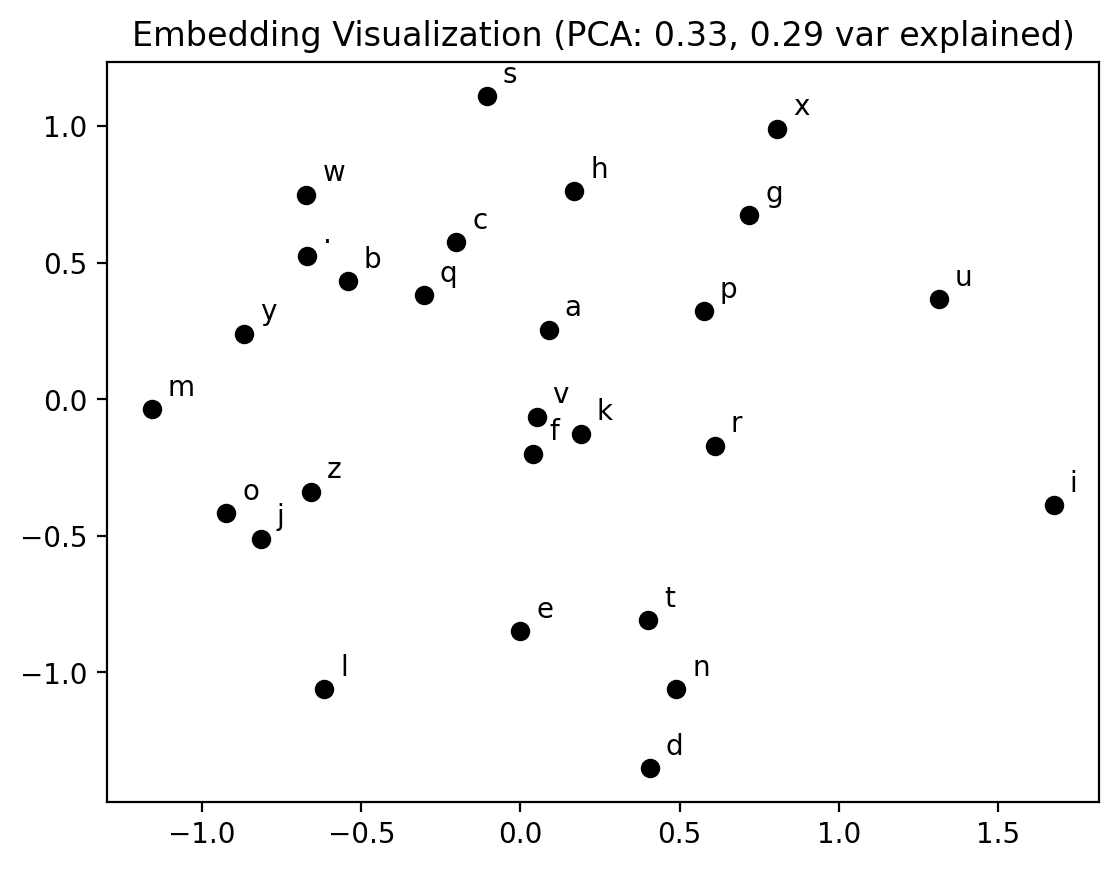

In [75]:
print("\nEmbedding visualization after training:")
plot_emb(model.emb, itos)

In [76]:
# Generate some names after training
print("Generated names after training:")
print("="*50)
for i in range(10):
    name = generate_name(model, itos, stoi, block_size)
    print(f"{i+1:2d}. {name}")



Generated names after training:
 1. uliti
 2. brajvat
 3. nassit
 4. maheet
 5. janukh
 6. monshi
 7. fachhotu
 8. beera
 9. razia
10. daya


Tuning knobs

1. Embedding size
2. MLP 
3. Context length